In [33]:
# get dataset
import pandas as pd

In [34]:
pd.read_excel("../../data/landing/tourism.xlsx", sheet_name="Table 1")

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,"TABLE 1: KEY DIRECT TOURISM AGGREGATE RESULTS,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NSW,Vic,Qld,SA,WA,Tas,NT,ACT,Total(a)
2,NaN,LEVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gross value added,$ million – basic prices,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006–07,9373.441383,6196.334496,7827.312576,1806.580839,3160.894444,906.352932,931.926639,588.155682,30790.998991
...,...,...,...,...,...,...,...,...,...,...
71,2019-20,167.8218,164.159405,127.996337,38.629807,64.419109,19.253642,6.706634,8.713294,597.700027
72,2020-21,117.106632,76.542315,97.688408,33.700056,49.228165,16.353383,5.218795,6.162259,402.000015
73,2021-22,106.061815,108.783277,113.018049,30.791072,53.805088,17.351924,6.18132,6.407452,442.399996
74,2022-23,172.5939,163.6159,145.6539,40.6245,66.7419,19.008,7.5081,10.4538,626.2


In [35]:
# drop first 4 rows
df = pd.read_excel("../../data/landing/tourism.xlsx", sheet_name="Table 1")

# Get Victoria row
victoria_row = df.iloc[4:21, [0, 2]]

# convert year column to second number in tuple
victoria_row = [(int(row[0][:4]) + 1, row[1]) for row in victoria_row.values]

# turn into dataframe
victoria_df = pd.DataFrame(victoria_row, columns=["year", "gdp_impact"])


In [36]:
victoria_df

,year,gdp_impact
0,2007,6196.334496
1,2008,6710.915310
2,2009,7220.045944
3,2010,7249.350586
4,2011,7769.698044
5,2012,8211.181412
6,2013,8748.545708
7,2014,9076.411873
8,2015,9676.499252
9,2016,10496.154175


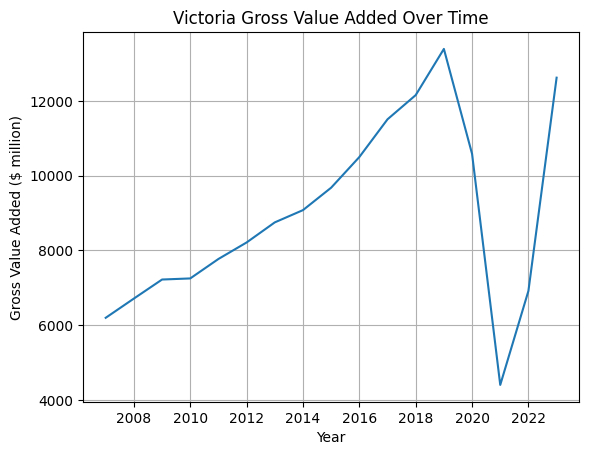

In [37]:
# graph data
import matplotlib.pyplot as plt

# BEGIN: graph data
plt.plot(victoria_df['year'], victoria_df['gdp_impact'])
plt.title('Victoria Gross Value Added Over Time')
plt.xlabel('Year')
plt.ylabel('Gross Value Added ($ million)')
plt.grid(True)  # Add grid
plt.show()
# END: graph data
# END: graph data

In [38]:
victoria_df

,year,gdp_impact
0,2007,6196.334496
1,2008,6710.915310
2,2009,7220.045944
3,2010,7249.350586
4,2011,7769.698044
5,2012,8211.181412
6,2013,8748.545708
7,2014,9076.411873
8,2015,9676.499252
9,2016,10496.154175


ADF Statistic: -0.08580973922952286
p-value: 0.9508337239896556


/opt/anaconda3/envs/ADS/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ADS/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/ADS/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


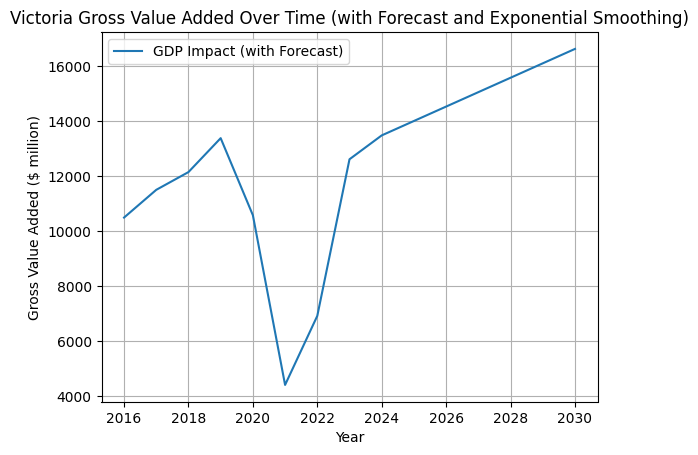

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


# Convert half years into whole years by averaging over them
victoria_df['year'] = victoria_df['year'].astype(int)
victoria_df = victoria_df.groupby('year').mean().reset_index()

# Create a complete range of years from the first to the last
full_years = pd.DataFrame({'year': np.arange(victoria_df['year'].min(), victoria_df['year'].max() + 1)})

# Merge the existing data with the full range of years, to fill missing years
victoria_full_df = pd.merge(full_years, victoria_df, on='year', how='left')

# Interpolate to fill in missing values for all years, including 2020-2022
victoria_full_df['gdp_impact'].interpolate(method='linear', inplace=True)

# Check for stationarity using Augmented Dickey-Fuller test
adf_test = adfuller(victoria_full_df['gdp_impact'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')


# Remove rows where differencing resulted in NaN
victoria_full_df.dropna(inplace=True)

# Exclude 2020-2022 for ARIMA model fitting
filtered_victoria_df = victoria_full_df[~victoria_full_df['year'].isin([2020, 2021, 2022])]

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the Exponential Smoothing model
exp_smoothing_model = ExponentialSmoothing(filtered_victoria_df['gdp_impact'], trend='add', seasonal=None)
exp_model_fit = exp_smoothing_model.fit()

# Forecast for 8 steps (years)
forecast = exp_model_fit.forecast(steps=7)

# Create a DataFrame for the forecasted values
forecast_years = np.arange(2024, 2031)
forecast_df = pd.DataFrame({'year': forecast_years, 'gdp_impact': forecast})

# Combine the original and forecasted data
combined_df = pd.concat([victoria_full_df, forecast_df], ignore_index=True)

# Filter the combined data for the years 2016-2030
filtered_combined_df = combined_df[(combined_df['year'] >= 2016) & (combined_df['year'] <= 2030)]

# Plot the filtered combined data
plt.plot(filtered_combined_df['year'], filtered_combined_df['gdp_impact'], label='GDP Impact (with Forecast)')
plt.title('Victoria Gross Value Added Over Time (with Forecast and Exponential Smoothing)')
plt.xlabel('Year')
plt.ylabel('Gross Value Added ($ million)')
plt.grid(True)
plt.legend()
plt.show()



In [40]:

# Save the filtered dataframe to a CSV file
filtered_combined_df.to_csv("../../data/curated/victoria_gdp_tourism.csv", index=False)